# Explore Trained CLIP Embeddings on Data

### Description

* Explore/analyze the cosine similarity of text and image CLIP embeddings.
* Validate that text-image pairs have high cosine similarities while unmatched text-image pairs have low cosine similarities.
* Explore how similar CLIP embeddings correspond to similar captions/images


### References on CLIP

* https://arxiv.org/pdf/2103.00020
* My notes on the CLIP paper: https://github.com/spencer-karofsky/aws_diffusion_model/blob/main/dall-e-2/research_notes/CLIP%202021.pdf or /dall-e-2/research_notes/CLIP 2021.pdf

### Authors

* Spencer Karofsky (https://github.com/spencer-karofsky)

### Sections

1. [Explore CLIP on Different Text Inputs](#explore-clip-on-different-text-inputs)
2. [Validate High Cosine Similarity Between Matched Text-Image Pairs](#validate-high-cosine-similarity-between-matched-text-image-pairs)
3. [Validate Low Cosine Similarity Between Unmatched Text-Image Pairs](#validate-low-cosine-similarity-between-unmatched-text-image-pairs)
4. [Explore Different Captions and Images With High CLIP Similarities](#explore-different-captions-and-images-with-high-clip-similarities)

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch.nn.functional as F
import torch

# Adds project root for dalle_core to use CLIPEmbedder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from dalle_core.clip.clip_embedder import CLIPEmbedder

# Adds dataset_utils path to import MidjourneyDataset
dataset_utils_dir = os.path.abspath(os.path.join(os.getcwd(), "../data/data_scripts"))
sys.path.append(dataset_utils_dir)
from dataset_utils import MidjourneyDataset

%matplotlib widget


In [2]:
# Instantiate CLIP Embedder 
clip_embedder = CLIPEmbedder()

### Explore CLIP on Different Text Inputs

##### CLIP Expected Input and Output Shapes

| Modality | Step                         | Shape                   | Description                                                                 |
|----------|------------------------------|--------------------------|-----------------------------------------------------------------------------|
| **Text** | Input                        | `List[str]`              | Raw text prompts (can be words, phrases, or full sentences, but each string is treated as an independent prompt)                        |
|          | Tokenized                    | `[B, 77]`                | Token IDs padded/truncated to 77 tokens (internal to the implementation)       |
|          | Output (default: global)     | `[B, 512]`               | Global text embedding — one 512-D vector representing the entire text prompt         |
| **Image**| Input                        | `List[PIL.Image]` or `[B, 3, H, W]` | Raw or preprocessed RGB images (3 color channels, H, W = pixel height and width of each image)            |
|          | Preprocessed                 | `[B, 3, H, W]`       | Normalized and resized tensor batch of images                              |
|          | Output (default: global)     | `[B, 512]`               | Global image embedding — one 512-D vector representing the entire image  |

##### Text (Validate `List[str]` -> `torch.Size([B, 512])`)

In [3]:
text_prompts = ['a dog',
                'a dog playing with a cat',
                'a blue dog on another planet riding a unicycle']

text_embeddings = clip_embedder.encode_text(text_prompts)

print(f'{text_embeddings.shape}') # expected: [3, 512]

torch.Size([3, 512])


##### Images (Validate `List[PIL.Image]` -> `torch.Size([B, 512])` and `torch.Size([B, 3, H, W])` -> `torch.Size([B, 512])`)

Unique images: 5980
Unique text captions: 1495


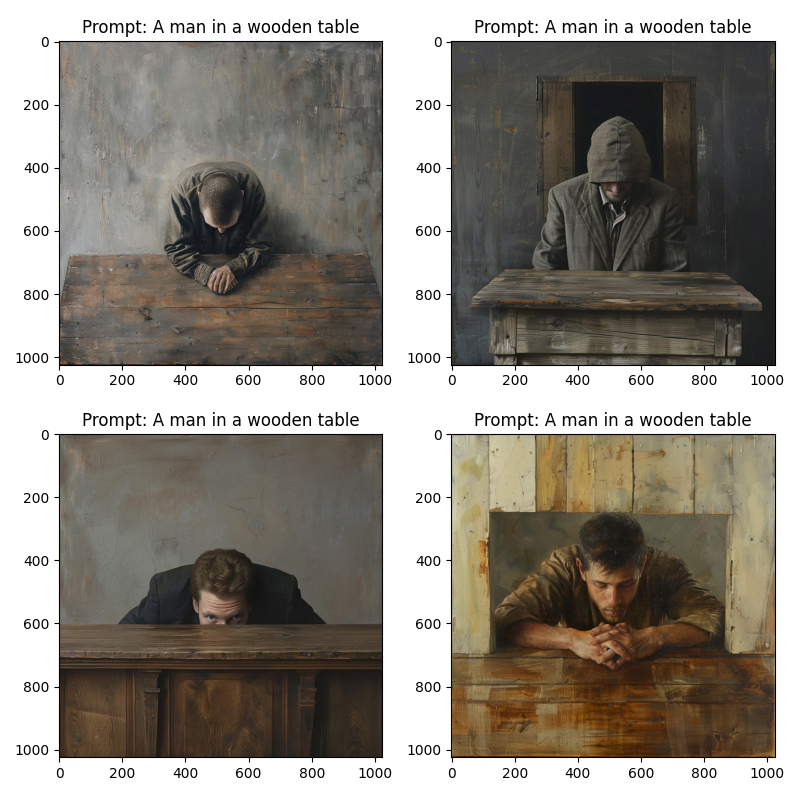

In [4]:
dataset = MidjourneyDataset(save_dir="../data/data_scripts/datasets/midjourney")

# Load and Visualize Images
print(f'Unique images: {len(dataset)}')
print(f'Unique text captions: {len(dataset) // 4}')
image, caption = dataset[0]
pairs = [dataset[i] for i in range(4)]

_, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i, pair in enumerate(pairs):
    ax[i].imshow(pair[0])
    ax[i].set_title(f'Prompt: {pair[1]}')
plt.tight_layout()
plt.show()

In [5]:
# Validate CLIP Embedding Sizes
image_embeddings = clip_embedder.encode_image([pair[0] for pair in pairs])

print(f'{image_embeddings.shape}') # expected: [4, 512]

torch.Size([4, 512])


### Validate High Cosine Similarity Between Matched Text-Image Pairs

In [6]:
# Given a (caption, image)-pair, the cosine similarity between the CLIP embeddings should be positive
# Recap: cosine similarity ranges from [-1, 1] (-1=perfect negative correleation, 0=no correlation, 1=perfect positive correlation)
text_embeddings = clip_embedder.encode_text([pair[1] for pair in pairs])
image_embeddings = clip_embedder.encode_image([pair[0] for pair in pairs])

similarities = F.cosine_similarity(text_embeddings, image_embeddings, dim=-1)
print(similarities) # observe relatively high and similar cosine similarities

tensor([0.3382, 0.3125, 0.3426, 0.3489], device='mps:0')


### Validate Low Cosine Similarity Between Unmatched Text-Image Pairs

In [7]:
# Show that random pairs will have close to zero cosine similarities
text_indices = torch.randperm(len(dataset))[:4]
img_indices = torch.randperm(len(dataset))[:4]

captions = [dataset[int(i)][1] for i in text_indices]
images = [dataset[int(i)][0] for i in img_indices]

text_embeddings = clip_embedder.encode_text(captions)
image_embeddings = clip_embedder.encode_image(images)

similarities = F.cosine_similarity(text_embeddings, image_embeddings, dim=-1)
print(similarities) # observe poor cosine similarities

tensor([0.1336, 0.0048, 0.1115, 0.0289], device='mps:0')


### Explore Different Captions and Images With High CLIP Similarities

In [8]:
# TODO